# Models

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
tweets = pd.read_csv("tweets.csv")

In [3]:
import emoji
def deEmoji(text):
    return emoji.get_emoji_regexp().sub(r'', text)

In [4]:
# Preprocess
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

def text_preprocess(text):
    text = re.sub(r'#', '', text) #Replace the # symbol with '' in every tweet
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text) #Replace hyperlinks with '' in every tweet
    text = re.sub(r'[^\w\d\s]+', '', text) #Remove all punctuations
    text = deEmoji(text) #Remove emoji
    text = re.sub(r'\n', '', text) #Remove \n
    
    #Remove all stopwords
    stopwords_eng = stopwords.words('english')
    pattern = re.compile(r'\b(' + r'|'.join(stopwords_eng) + r')\b\s*')
    text = pattern.sub('', text)
    
    #Apply stem
    ps = PorterStemmer()
    tk = TweetTokenizer(preserve_case=False, strip_handles = True)
    tweet_tokens = tk.tokenize(text)
    tweet_finish = ''
    for token in tweet_tokens:
        stem = ps.stem(token)
        tweet_finish += (stem + ' ')
    return tweet_finish  

In [5]:
tweets = tweets[['medical_device', 'text']]

In [6]:
tweets.columns

Index(['medical_device', 'text'], dtype='object')

In [7]:
length = len(tweets.text)
for i in range(length):
    tweets.text.iloc[i] = text_preprocess(tweets.text.iloc[i])

In [8]:
tweets

,medical_device,text
0,False,yall know i know im never leav boy alon jnj
1,False,superkelli 24 such funni scene jnj
2,False,jampjohnson flagform confirm continu possibl j...
3,False,jnj daili rsi hasnt touch 69 sinc februari 202...
4,False,we outstand opportun join non clinic safeti te...
...,...,...
6489,False,bought jnj call 904 155 53 entri
6490,False,wikileak pamper huggi johnson johnson jnj hist...
6491,False,wikileak pamper huggi johnson johnson jnj hist...
6492,False,hostess_snack jnj kick theyr kick get done


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

x=tweets['medical_device'].value_counts()
print(x)

False    5859
True      635
Name: medical_device, dtype: int64


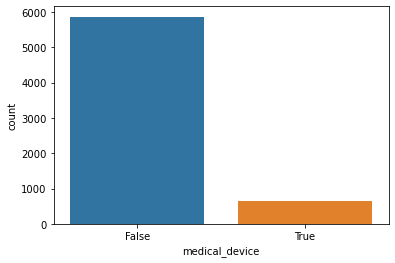

In [10]:
ax = sns.countplot(x="medical_device", data=tweets)

In [11]:
import gensim
from gensim.models import Word2Vec #Word2Vec is mostly used for huge datasets

# create Word2vec model
#here words_f should be a list containing words from each document. say 1st row of the list is words from the 1st document/sentence
#length of words_f is number of documents/sentences in your dataset
tweets['clean_text_tok']=[nltk.word_tokenize(i) for i in tweets['text']] #convert preprocessed sentence to tokenized sentence
model = Word2Vec(tweets['clean_text_tok'],min_count=1)  #min_count=1 means word should be present at least across all documents,
#if min_count=2 means if the word is present less than 2 times across all the documents then we shouldn't consider it


w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))  #combination of word and its vector

#for converting sentence to vectors/numbers from word vectors result by Word2Vec
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

## OverSampling

In [12]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(tweets["text"].values.reshape(-1,1), tweets["medical_device"])

In [13]:
X_res = pd.Series(X_res.ravel())

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res,
                                                    test_size=0.2,
                                                    shuffle=True, 
                                                    #stratify=tweets["medical_device"],
                                                    random_state=42)

In [15]:
y_train.value_counts()

True     4697
False    4677
Name: medical_device, dtype: int64

In [16]:
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  
X_test_tok= [nltk.word_tokenize(i) for i in X_test]

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

In [18]:
modelw = MeanEmbeddingVectorizer(w2v)
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_test_vectors_w2v = modelw.transform(X_test_tok)

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

## LR (tf-idf)

In [20]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)

from sklearn.model_selection import GridSearchCV

lr_param = {'solver' : ['liblinear'], 'C':np.logspace(-4, 4, 20),'penalty' : ['l2']}
lr_tfidf= GridSearchCV(LogisticRegression(), lr_param)
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  #model

#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_test_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
 
print('Best estimators: ', lr_tfidf.best_params_)

print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)  

Best estimators:  {'C': 10000.0, 'penalty': 'l2', 'solver': 'liblinear'}
              precision    recall  f1-score   support

       False       1.00      0.98      0.99      1182
        True       0.98      1.00      0.99      1162

    accuracy                           0.99      2344
   macro avg       0.99      0.99      0.99      2344
weighted avg       0.99      0.99      0.99      2344

Confusion Matrix: [[1162   20]
 [   0 1162]]
AUC: 0.9975485699141746


## LR (w2v)

In [22]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression (W2v)
lr_w2v_param = {'solver' : ['liblinear'], 'C':np.logspace(-4, 4, 20),'penalty' : ['l2']}

lr_w2v=GridSearchCV(LogisticRegression(), lr_w2v_param)
lr_w2v.fit(X_train_vectors_w2v, y_train)  #model

#Predict y value for test dataset
y_predict = lr_w2v.predict(X_test_vectors_w2v)
y_prob = lr_w2v.predict_proba(X_test_vectors_w2v)[:,1]

print('Best estimators: ', lr_w2v.best_params_)

print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)  

Best estimators:  {'C': 3792.690190732246, 'penalty': 'l2', 'solver': 'liblinear'}
              precision    recall  f1-score   support

       False       0.87      0.85      0.86      1182
        True       0.85      0.87      0.86      1162

    accuracy                           0.86      2344
   macro avg       0.86      0.86      0.86      2344
weighted avg       0.86      0.86      0.86      2344

Confusion Matrix: [[1005  177]
 [ 149 1013]]
AUC: 0.9374743353399093


## NB (tf-idf)

In [21]:
#FITTING THE CLASSIFICATION MODEL using Naive Bayes(tf-idf)
#It's a probabilistic classifier that makes use of Bayes' Theorem, a rule that uses probability to make predictions based on prior knowledge of conditions that might be related. This algorithm is the most suitable for such large dataset as it considers each feature independently, calculates the probability of each category, and then predicts the category with the highest probability.

nb_param = {'alpha': [0.0001,0.001,0.1, 1]}
nb_tfidf = GridSearchCV(MultinomialNB(), nb_param)
nb_tfidf.fit(X_train_vectors_tfidf, y_train)  #model

#Predict y value for test dataset
y_predict = nb_tfidf.predict(X_test_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
 
print('Best estimators: ', nb_tfidf.best_params_)
    
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)  

Best estimators:  {'alpha': 0.0001}
              precision    recall  f1-score   support

       False       1.00      0.96      0.98      1182
        True       0.96      1.00      0.98      1162

    accuracy                           0.98      2344
   macro avg       0.98      0.98      0.98      2344
weighted avg       0.98      0.98      0.98      2344

Confusion Matrix: [[1137   45]
 [   1 1161]]
AUC: 0.9971772514277559


## Gradient Boosting (tf-idf)

In [45]:
from sklearn.ensemble import GradientBoostingClassifier
gbdt_tfidf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.2, max_depth=15, random_state=42)
gbdt_tfidf.fit(X_train_vectors_tfidf, y_train)  #model

#Predict y value for test dataset
y_predict = gbdt_tfidf.predict(X_test_vectors_tfidf)
y_prob = gbdt_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
 
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

       False       1.00      0.97      0.99      1182
        True       0.97      1.00      0.99      1162

    accuracy                           0.99      2344
   macro avg       0.99      0.99      0.99      2344
weighted avg       0.99      0.99      0.99      2344

Confusion Matrix: [[1151   31]
 [   0 1162]]
AUC: 0.9969049512043823


## Gradient Boosting (w2v)

In [51]:
gbdt_w2v = GradientBoostingClassifier(n_estimators=100, learning_rate=0.2, max_depth=15, random_state=42)
gbdt_w2v.fit(X_train_vectors_w2v, y_train)  #model

#Predict y value for test dataset
y_predict = gbdt_w2v.predict(X_test_vectors_w2v)
y_prob = gbdt_w2v.predict_proba(X_test_vectors_w2v)[:,1]
 
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

       False       1.00      0.98      0.99      1182
        True       0.98      1.00      0.99      1162

    accuracy                           0.99      2344
   macro avg       0.99      0.99      0.99      2344
weighted avg       0.99      0.99      0.99      2344

Confusion Matrix: [[1157   25]
 [   0 1162]]
AUC: 0.9955543712194682


## XGBoost (tf-idf)

In [50]:
from xgboost import XGBClassifier
xgb_tfidf = XGBClassifier(n_estimators=100, learning_rate=0.2, max_depth=15, random_state=42)
xgb_tfidf.fit(X_train_vectors_tfidf, y_train)  #model

#Predict y value for test dataset
y_predict = xgb_tfidf.predict(X_test_vectors_tfidf)
y_prob = xgb_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
 
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

[16:57:49] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

       False       1.00      0.98      0.99      1182
        True       0.98      1.00      0.99      1162

    accuracy                           0.99      2344
   macro avg       0.99      0.99      0.99      2344
weighted avg       0.99      0.99      0.99      2344

Confusion Matrix: [[1154   28]
 [   1 1161]]
AUC: 0.9968401524881251


## XGBoost (w2v)

In [49]:
xgb_w2v = XGBClassifier(n_estimators=100, learning_rate=0.2, max_depth=15, random_state=42)
xgb_w2v.fit(X_train_vectors_w2v, y_train)  #model

#Predict y value for test dataset
y_predict = xgb_w2v.predict(X_test_vectors_w2v)
y_prob = xgb_w2v.predict_proba(X_test_vectors_w2v)[:,1]
 
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

[16:57:36] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

       False       1.00      0.97      0.98      1182
        True       0.97      1.00      0.98      1162

    accuracy                           0.98      2344
   macro avg       0.98      0.98      0.98      2344
weighted avg       0.98      0.98      0.98      2344

Confusion Matrix: [[1142   40]
 [   0 1162]]
AUC: 0.9973206822940784
